# Augenblick and Rabin, 2019, "An Experiment on Time Preference and Misprediction in Unpleasant Tasks", Table 2

#### Authors:  

- Massimiliano Pozzi (Bocconi University, pozzi.massimiliano@studbocconi.it)
- Salvatore Nunnari (Bocconi University, salvatore.nunnari@unibocconi.it)

#### Description:

The code in this Jupyter notebook performs the individual estimates to replicate columns 1, 2, 3, 4 of Table 2

This notebook was tested with the following packages versions:
- Pozzi:   (Anaconda 4.10.3 on Windows 10 Pro) : python 3.8.3, numpy 1.18.5, pandas 1.0.5, scipy 1.5.0, matplotlib 3.2.2
- Nunnari: (Anaconda 4.10.1 on macOS 10.15.7): python 3.8.10, numpy 1.20.2, pandas 1.2.4, scipy 1.6.2, matplotlib 3.3.4

In [38]:
# Import the necessary libraries

import numpy as np
import pandas as pd
from   scipy.stats import norm
import scipy.optimize as opt
import matplotlib.pyplot as plt
from outliers import smirnov_grubbs as grubbs
from scipy.stats import pearsonr as pear

## 1. Data Cleaning and Data Preparation

We import the dataset containing observations for all 100 individuals. We then remove observations when a bonus was offered and create dummy variables that will be useful for estimation: pb is equal to one if the subject completed 10 mandatory tasks on subject-day (this is used to estimate the projection bias parameter &alpha;), ind_effort10 and ind_effort110 are equal to one if the subject completed 10 or 110 tasks respectively (and they are used for the Tobit correction when computing the likelihood).

In [39]:
# Import the dataset 

dt = pd.read_stata('../input/decisions_data.dta')   # full sample

# Remove observations when a bonus was offered and create dummy variables. 

dt = dt[dt.bonusoffered !=1]   # remove observations when a bonus was offered
dt['pb']= dt['workdone1']/10   # pb dummy variable. workdone1 can either be 10 or 0, so dividing the variable by 10 creates our dummy
dt['ind_effort10']  = (dt['effort']==10).astype(int)   # ind_effort10 dummy
dt['ind_effort110'] = (dt['effort']==110).astype(int)  # ind_effort110 dummy

## 2. Define the Model and the Likelihood (Section 3 in the Paper)

The agent needs to choose the optimal effort e to solve a simple tradeoff problem between disutility of effort and consumption utility derived from the consequent payment. More specifically, the agent takes a decision at a time k to complete a certain number of tasks at time t and to get paid a wage w per task at time T. Assuming the agent discounts utility using quasi-hyperbolic discounting and has a convex cost function C(e) the problem can be conveniently written as:

$$ \max_{{e}} \; \delta^{T-k}⋅(e⋅w)- \frac{1}{\beta^{I(k=t)}}⋅\frac{1}{\beta_h^{I(p=1)}}⋅\delta^{t-k}⋅ \frac{e^\gamma}{\phi⋅\gamma} $$

Where the last term is a two parameter power cost function, I(k=t) is an indicator function equal to one if the decision occurs in the same period as the effort and I(p=1) is an indicator that the decision is a prediction, &beta;<sub>h</sub> is the perceived present bias parameter (that is, the agent's degree of awareness of his present bias), and &delta; is the standard time discounting parameter. Taking the derivative of the maximization problem above with respect to effort yields the following first order condition:

$$  e^*= \left(\frac{\delta^{T-k}⋅\phi⋅w}{\frac{1}{\beta^{I(k=t)}}⋅\frac{1}{\beta_h^{I(p=1)}}⋅\delta^{t-k}} \right)^{\frac{1}{\gamma-1}} $$

This is the optimal effort level, or what we will call in the code the predicted choice. To model heterogeneity, the authors assume that the observed effort is distributed as the predicted effort plus an implementation error which is Gaussian with mean zero and standard deviation sigma, so that the likelihood of observing an effort decision e<sub>j</sub> in the data is equal to:

$$ L(e_j)= \phi \left(\frac{e^*_j-e_j}{\sigma}\right)$$

where &phi; is the pdf of a standard normal. 

To deal with corner solutions we apply a Tobit correction, so that the likelihood to maximize is:

$$ L^{tobit}(e_j)=(1-I(e=10)-I(e=110))⋅\phi \left(\frac{e^*_j-e_j}{\sigma}\right) + I(e=10)⋅\left(1- \Phi \left(\frac{e_j^*-10}{\sigma}\right)\right)+I(e=110)⋅ \Phi \left(\frac{e_j^*-110}{\sigma}\right) $$

where &Phi;(⋅) is the cdf of a standard normal, while I(e=10) and I(e=110) are the indicators ind_effort10 and ind_effort110 explained above. Note that, to keep the code simple, in this notebook we call effort the number of tasks performed by the agent, that is, the number of tasks chosen by the agent (ranging between 0 and 100) plus the compulsory 10 tasks. In the paper, the authors call effort just the number of tasks chosen by the agent (and, thus, they add 10 tasks to get total effort). This explains the differences between the equations in this notebook and equation (7), (8) and (10) in Section 3 of the paper. 

Our goal is to minimize the negative of the sum of the logarithms of L<sup>tobit</sup>.

In [40]:
# the function negloglike computes the negative of the log likelihood of observing our data given the parameters of the model.

# parameters:

# beta is the present bias parameter
# betahat is the perceived present bias parameter
# delta is the usual time-discounting parameter
# gamma and phi are the two parameters controlling the cost of effort function
# alpha is the projection bias parameter
# sigma is the standard deviation of the normal error term ϵ

# args:

# netdistance is (T-k)-(t-k) = T-t, the difference between the payment date T and the work time t
# wage is the amount paid per task in a certain session
# today is a dummy variable equal to one if the decision involves the choice of work today
# prediction is a dummy variable equal to one if the decision involves the choice of work in the future
# pb is a dummy equal to one if the subject completed 10 mandatory tasks on subject-day 
# effort is the number of tasks completed by a subject in a session. It can range from a minimum of 10 to a maximum of 110
# ind_effort10 is a dummy equal to one if the subject's effort was equal to 10
# ind_effort110 is a dummy equal to one if the subject's effort was equal to 110
# spec identifies the specification. It is one for column one, two for column two, etc up to colmn four


def negloglike(params, *args):
    
    netdistance, wage, today, prediction, pb, effort, ind_effort10, ind_effort110, spec = args
    
    if spec != 4:
        beta, betahat, delta, gamma, phi, sigma = params          # columns 1, 2, 3 do not estimate α
    else:
        beta, betahat, delta, gamma, phi, alpha, sigma = params
    
    # We use np.array to allow for element-wise operations
    
    netdistance = np.array(netdistance)
    wage = np.array(wage)
    today = np.array(today)
    prediction = np.array(prediction)
    pb = np.array(pb)
    effort = np.array(effort)
    ind_effort10 = np.array(ind_effort10)
    ind_effort110 = np.array(ind_effort110)
    
    # predchoice is the predicted choice coming from the optimality condition of the subject
    # if we are estimating the projection bias parameter α (column 4) we need to modify the predicted choice
    
    predchoice=((phi*(delta**netdistance)*(beta**today)*(betahat**prediction)*wage)**(1/(gamma-1)))

    if spec==4: predchoice = predchoice -pb*alpha
        
    # prob is a 1x8049 vector containing the probability of observing the effort of an individual. If effort is 10 or 110 we apply a Tobit correction
    
    prob = (1-ind_effort10-ind_effort110)*norm.pdf(effort, predchoice, sigma)+ind_effort10*(1 - norm.cdf((predchoice-effort)/sigma))+ind_effort110*norm.cdf((predchoice-effort)/sigma)
            
    # we now look at the vector prob and add a small value close to zero if prob=0 or subtract a small value close to zero if prob=1. This is necessary to avoid problems when taking logs
        
    index_p0 = [i for i in range(0,len(prob)) if prob[i]==0] # vector containing the indexes when prob=0
    index_p1 = [i for i in range(0,len(prob)) if prob[i]==1] # vector containing the indexes when prob=1
    
    # use a for loop to change the values
    
    for i in index_p0:
        prob[i] = 1E-4
        
    for i in index_p1:
        prob[i] = 1 - 1E-4
    
    negll = - np.sum(np.log(prob)) # negative log likelihood
    
    return negll

## 3. Estimation

### Point Estimates 

We define the function that computes the individual estimates for columns 1, 2, 3 and 4 of Table 2. There are four specifications to consider: the first column uses the entire sample, the second column uses only observations for which the decision date is less than 4, the third column uses only observations for which the decision date is from time 4 onwards, and the fourth column uses the full sample but estimates also the projection bias parameter.

In [41]:
# Define an auxiliary function.
# This function takes as input a dataset, a scalar and a specification argument and returns the relevant individual-level dataframe containing only observations for individual whose ID is equal to that scalar

def getind(dataset, wid, spec):
    dataset_ind = dataset[dataset.wid == wid]
    if spec == 2: dataset_ind = dataset_ind[dataset_ind.decisiondatenum < 4]  # second column specification
    if spec == 3: dataset_ind = dataset_ind[dataset_ind.decisiondatenum >= 4] # third column specification    
    return dataset_ind

# Define the function that estimates the model

def estimate(dataset, spec):
    
    # Define the vector containing the initial guesses and the vectors that will contain our results
    # res_params will be a 1x100 vector, each element is a 1x6 or 1x7 vector containing the estimates for the parameters
    # res_like will be a 1x100 vector containing the log likelihood obtained, while res_wid will be a 1x100 vector containing the wid 
    # of the individual for which we find the estimates. res_conv is a 1x100 vector of 1 (converged) or 0 (not converged)
    
    beta_init, betahat_init, delta_init, gamma_init, phi_init, alpha_init, sigma_init = 1, 1, 1, 2, 250, 3, 50
    res_param, res_like, res_wid, res_conv = [], [], [], []
    
    # compute the individual estimates and save the results
    
    for wid in np.unique(dataset.wid):      # loop over individuals' ID
        
        params_init = [beta_init, betahat_init, delta_init, gamma_init, phi_init, alpha_init, sigma_init] # initial parameters for the algorithm
        params_nopb = [beta_init, betahat_init, delta_init, gamma_init, phi_init, sigma_init]             # initial parameters for the algorithm, no alpha
        
        dt_ind = getind(dataset, wid, spec) # get the relevant individual dataframe that depends also on the specification
        
        # args needed to compute the individual likelihood
        args_ind=(dt_ind['netdistance'], dt_ind['wage'], dt_ind['today'], dt_ind['prediction'], dt_ind['pb'], 
                  dt_ind['effort'], dt_ind['ind_effort10'],dt_ind['ind_effort110'], spec)
        
        if spec != 4: # first three columns do not have the projection bias parameter
                
        # We run each estimation twice. The second one starting from the previous argmin to see if we were stuck on a local minima
        # This is usually not necessary, but also not expensive in terms of time so it can be worth it to do it
                
            j = 0
            while (j<2):
                sol = opt.minimize(negloglike, params_nopb, args=(args_ind), method='Nelder-Mead', options={'maxiter': 2500})
                params_nopb = sol.x
                j = j+1
        else:
            j = 0
            while (j<2):
                sol = opt.minimize(negloglike, params_init, args=(args_ind), method='Nelder-Mead', options={'maxiter': 4000}) # the specification with projection bias usually needs more iterations
                params_init = sol.x
                j = j+1

        res_param.append(sol.x)
        res_like.append(-sol.fun)
        res_wid.append(wid)
        res_conv.append(sol.success)
            
        if wid == 25.0: print("25% done")
        if wid == 50.0: print("50% done")
        if wid == 75.0: print("75% done")
        if wid == 100.0: print("100% done")

    return res_param, res_like, res_wid, res_conv

In [42]:
# This cell computes the estimates for column (1) and stores the results.

import warnings
warnings.filterwarnings('ignore') # This is to avoid showing RuntimeWarning in the notebook regarding overflow when computing the negloglike. This warning does not affect the results.
                                  # We could avoid it by adding a check on the value of predchoice. We are using this command since we are sure of the results,
                                  # we do not suggest suppressing errors otherwise.

res1 = estimate(dt,1)
param1 = res1[0]
like1  = res1[1]
conv1  = res1[2]

25% done
50% done
75% done
100% done


In [43]:
# This cell computes the estimates for column (2) and stores the results.

res2 = estimate(dt,2)
param2 = res2[0]
like2  = res2[1]
conv2  = res2[2]

25% done
50% done
75% done
100% done


In [44]:
# This cell computes the estimates for column (3) and stores the results.

res3 = estimate(dt,3)
param3 = res3[0]
like3  = res3[1]
conv3  = res3[2]

25% done
50% done
75% done
100% done


In [45]:
# This cell computes the estimates for column (4) and stores the results.

res4 = estimate(dt,4)
param4 = res4[0]
like4  = res4[1]
conv4  = res4[2]

25% done
50% done
75% done
100% done


## 4. Print and Save Estimation Results

From the initial 100 subjects, the authors drop those subjects whose estimates their Stata algorithm was unable to find, took longer than 200 iterations to converge, or were outliers (identified by a grubbs test). Since we are using a different programming language and a different minimization algorithm (which, in our case, is gradient-free), we managed to find estimates for all 100 individuals. Below, we show results for both the subset of individuals considered by the authors (which we identified by running their "03MergeIndMLEAndConstructMainSample.do" file) and the whole sample.

First, we show results for the subset of individuals considered by the authors.

In [46]:
# Unpack the results:

# The params vectors we obtained are a list of lists where the first element is a list containing the estimates for the first individual
# in the dataset, the second element is a list containing the estimates for the second individual in the dataset, etc. 

# For column 1:
b1  = np.array([item[0] for item in param1])
bh1 = np.array([item[1] for item in param1])
d1= np.array([item[2] for item in param1])
g1= np.array([item[3] for item in param1])
p1  = np.array([item[4] for item in param1])
s1= np.array([item[5] for item in param1])

# For column 2:
b2 = np.array([item[0] for item in param2])
bh2= np.array([item[1] for item in param2])
d2 = np.array([item[2] for item in param2])
g2 = np.array([item[3] for item in param2])
p2   = np.array([item[4] for item in param2])
s2 = np.array([item[5] for item in param2])

# For column 3:
b3 = np.array([item[0] for item in param3])
bh3  = np.array([item[1] for item in param3])
d3 = np.array([item[2] for item in param3])
g3 = np.array([item[3] for item in param3])
p3   = np.array([item[4] for item in param3])
s3 = np.array([item[5] for item in param3])

# For column 4:
b4  = np.array([item[0] for item in param4])
bh4 = np.array([item[1] for item in param4])
d4 = np.array([item[2] for item in param4])
g4 = np.array([item[3] for item in param4])
p4   = np.array([item[4] for item in param4])
s4 = np.array([item[6] for item in param4])
a4 = np.array([item[5] for item in param4])

In [47]:
# Load the dataset containing the wid of the individuals to keep in the different specifications. We created this csv file by running
# their "03MergeIndMLEAndConstructMainSample.do" do-file. This do-file returns 67 individuals to keep for specification 4, while in the 
# paper the number of individuals is 68. We do not know the reason for this difference.

ind_keep = pd.read_csv('../input/ind_to_keep.csv')   # 4 columns, each containing individuals to keep in each specification

# keep parameters only for individuals in ind_keep

# For column 1:
mc1 = pd.DataFrame({'wid':np.unique(dt.wid),'b':b1,'bh':bh1,'d':d1,'g':g1})
dc1 = mc1[mc1.wid.isin(ind_keep.wid_col1)]

# For column 2:
mc2 = pd.DataFrame({'wid':np.unique(dt.wid),'b':b2,'bh':bh2,'d':d2,'g':g2})
dc2 = mc2[mc2.wid.isin(ind_keep.wid_col2)]

# For column 3:
mc3 = pd.DataFrame({'wid':np.unique(dt.wid),'b':b3,'bh':bh3,'d':d3,'g':g3})
dc3 = mc3[mc3.wid.isin(ind_keep.wid_col3)]

# For column 4:
mc4 = pd.DataFrame({'wid':np.unique(dt.wid),'b':b4,'bh':bh4,'d':d4,'g':g4,'a':a4})
dc4 = mc4[mc4.wid.isin(ind_keep.wid_col4)]

In [48]:
# Print the results using the authors' subset of individuals 

from IPython.display import display

pnames = ["mean(β)", "median(β)", "sd(β)", "mean(β_h)", "median(β_h)", "sd(β_h)", "mean(δ)", "median(δ)", "sd(δ)",
          "mean(γ)", "median(γ)", "sd(γ)","mean(α)", "median(α)", "sd(α)", "P[β]<1", "P[β_h]<1", 'r(β,β_h)','p-value r(β,β_h)',
          'Observations']
col1 = np.round([np.mean(dc1.b), np.median(dc1.b), np.std(dc1.b),np.mean(dc1.bh), np.median(dc1.bh), np.std(dc1.bh),
                np.mean(dc1.d), np.median(dc1.d), np.std(dc1.d),np.mean(dc1.g), np.median(dc1.g), np.std(dc1.g),
                0,0,0,np.round(np.mean(dc1.b<1),2),np.round(np.mean(dc1.bh<1),2),np.corrcoef(dc1.b,dc1.bh)[0,1],
                np.round(pear(dc1.b, dc1.bh)[1],3),len(dc1.b)],3)
col2 = np.round([np.mean(dc2.b), np.median(dc2.b), np.std(dc2.b),np.mean(dc2.bh), np.median(dc2.bh), np.std(dc2.bh),
                np.mean(dc2.d), np.median(dc2.d), np.std(dc2.d),np.mean(dc2.g), np.median(dc2.g), np.std(dc2.g),
                0,0,0,np.round(np.mean(dc2.b<1),2),np.round(np.mean(dc2.bh<1),2),np.corrcoef(dc2.b,dc2.bh)[0,1],
                np.round(pear(dc2.b, dc2.bh)[1],3),len(dc2.b)],3)
col3 = np.round([np.mean(dc3.b), np.median(dc3.b), np.std(dc3.b),np.mean(dc3.bh), np.median(dc3.bh), np.std(dc3.bh),
                np.mean(dc3.d), np.median(dc3.d), np.std(dc3.d),np.mean(dc3.g), np.median(dc3.g), np.std(dc3.g),
                0,0,0,np.round(np.mean(dc3.b<1),2),np.round(np.mean(dc3.bh<1),2),np.corrcoef(dc3.b,dc3.bh)[0,1],
                np.round(pear(dc3.b, dc3.bh)[1],3),len(dc3.b)],3)
col4 = np.round([np.mean(dc4.b), np.median(dc4.b), np.std(dc4.b),np.mean(dc4.bh), np.median(dc4.bh), np.std(dc4.bh),
                np.mean(dc4.d), np.median(dc4.d), np.std(dc4.d),np.mean(dc4.g), np.median(dc4.g), np.std(dc4.g),
                np.mean(dc4.a), np.median(dc4.a), np.std(dc4.a),np.round(np.mean(dc4.b<1),2),np.round(np.mean(dc4.bh<1),2),
                np.corrcoef(dc4.b,dc4.bh)[0,1],np.round(pear(dc4.b, dc4.bh)[1],3),len(dc4.b)],3)
at1 = pd.DataFrame({"":pnames, "Primary Estimation":col1, "Early Decisions":col2, "Later Decisions":col3, "Proj. Bias":col4})

print("Table 2: Summary statistics for individual structural estimates")
display(at1)

Table 2: Summary statistics for individual structural estimates


,,Primary Estimation,Early Decisions,Later Decisions,Proj. Bias
0,mean(β),0.794,0.855,0.874,0.772
1,median(β),0.824,0.885,0.901,0.807
2,sd(β),0.284,0.336,0.242,0.280
3,mean(β_h),0.984,0.989,0.980,0.985
4,median(β_h),0.988,0.991,0.984,0.996
5,sd(β_h),0.119,0.152,0.097,0.117
6,mean(δ),1.016,1.010,1.006,1.017
7,median(δ),1.008,1.005,1.004,1.008
8,sd(δ),0.035,0.023,0.024,0.035
9,mean(γ),2.138,2.144,2.042,2.263


Second, we present results including our estimates for those subjects the Stata algorithm was unable to converge in less than 200 iterations. As the authors do, we remove outliers using a grubbs test with alpha at 1%.

In [49]:
# perform the grubbs test (alpha=1%):

beta1 = grubbs.test(b1, alpha=.01)
betahat1 = grubbs.test(bh1, alpha=.01)
delta1 = grubbs.test(d1, alpha=.01)
gamma1 = grubbs.test(g1, alpha=.01)
beta2 = grubbs.test(b2, alpha=.01)
betahat2 = grubbs.test(bh2, alpha=.01)
delta2 = grubbs.test(d2, alpha=.01)
gamma2 = grubbs.test(g2, alpha=.01)
beta3 = grubbs.test(b3, alpha=.01)
betahat3 = grubbs.test(bh3, alpha=.01)
delta3 = grubbs.test(d3, alpha=.01)
gamma3 = grubbs.test(g3, alpha=.01)
beta4 = grubbs.test(b4, alpha=.01)
betahat4 = grubbs.test(bh4, alpha=.01)
delta4 = grubbs.test(d4, alpha=.01)
gamma4 = grubbs.test(g4, alpha=.01)
alpha4 = grubbs.test(a4, alpha=.01)

# we keep only those individuals for which none of the parameters are removed by the grubbs test

# For column 1: 

dc1 = mc1[mc1.b.isin(beta1)]
dc1 = dc1[dc1.bh.isin(betahat1)]
dc1 = dc1[dc1.d.isin(delta1)]
dc1 = dc1[dc1.g.isin(gamma1)]

# For column 2:

dc2 = mc2[mc2.b.isin(beta2)]
dc2 = dc2[dc2.bh.isin(betahat2)]
dc2 = dc2[dc2.d.isin(delta2)]
dc2 = dc2[dc2.g.isin(gamma2)]

# For column 3:

dc3 = mc3[mc3.b.isin(beta3)]
dc3 = dc3[dc3.bh.isin(betahat3)]
dc3 = dc3[dc3.d.isin(delta3)]
dc3 = dc3[dc3.g.isin(gamma3)]

# For column 4:

dc4 = mc4[mc4.b.isin(beta4)]
dc4 = dc4[dc4.bh.isin(betahat4)]
dc4 = dc4[dc4.d.isin(delta4)]
dc4 = dc4[dc4.g.isin(gamma4)]
dc4 = dc4[dc4.a.isin(alpha4)]

In [50]:
# Print the results using our set of individuals

from IPython.display import display

pnames = ["mean(β)", "median(β)", "sd(β)", "mean(β_h)", "median(β_h)", "sd(β_h)", "mean(δ)", "median(δ)", "sd(δ)",
          "mean(γ)", "median(γ)", "sd(γ)","mean(α)", "median(α)", "sd(α)", "P[β]<1", "P[β_h]<1", 'r(β,β_h)','p-value r(β,β_h)',
          'Observations']
col1 = np.round([np.mean(dc1.b), np.median(dc1.b), np.std(dc1.b),np.mean(dc1.bh), np.median(dc1.bh), np.std(dc1.bh),
                np.mean(dc1.d), np.median(dc1.d), np.std(dc1.d),np.mean(dc1.g), np.median(dc1.g), np.std(dc1.g),
                0,0,0,np.round(np.mean(dc1.b<1),2),np.round(np.mean(dc1.bh<1),2),np.corrcoef(dc1.b,dc1.bh)[0,1],
                np.round(pear(dc1.b, dc1.bh)[1],3),len(dc1.b)],3)
col2 = np.round([np.mean(dc2.b), np.median(dc2.b), np.std(dc2.b),np.mean(dc2.bh), np.median(dc2.bh), np.std(dc2.bh),
                np.mean(dc2.d), np.median(dc2.d), np.std(dc2.d),np.mean(dc2.g), np.median(dc2.g), np.std(dc2.g),
                0,0,0,np.round(np.mean(dc2.b<1),2),np.round(np.mean(dc2.bh<1),2),np.corrcoef(dc2.b,dc2.bh)[0,1],
                np.round(pear(dc2.b, dc2.bh)[1],3),len(dc2.b)],3)
col3 = np.round([np.mean(dc3.b), np.median(dc3.b), np.std(dc3.b),np.mean(dc3.bh), np.median(dc3.bh), np.std(dc3.bh),
                np.mean(dc3.d), np.median(dc3.d), np.std(dc3.d),np.mean(dc3.g), np.median(dc3.g), np.std(dc3.g),
                0,0,0,np.round(np.mean(dc3.b<1),2),np.round(np.mean(dc3.bh<1),2),np.corrcoef(dc3.b,dc3.bh)[0,1],
                np.round(pear(dc3.b, dc3.bh)[1],3),len(dc3.b)],3)
col4 = np.round([np.mean(dc4.b), np.median(dc4.b), np.std(dc4.b),np.mean(dc4.bh), np.median(dc4.bh), np.std(dc4.bh),
                np.mean(dc4.d), np.median(dc4.d), np.std(dc4.d),np.mean(dc4.g), np.median(dc4.g), np.std(dc4.g),
                np.mean(dc4.a), np.median(dc4.a), np.std(dc4.a),np.round(np.mean(dc4.b<1),2),np.round(np.mean(dc4.bh<1),2),
                np.corrcoef(dc4.b,dc4.bh)[0,1],np.round(pear(dc4.b, dc4.bh)[1],3),len(dc4.b)],3)
at1 = pd.DataFrame({"":pnames, "Primary Estimation":col1, "Early Decisions":col2, "Later Decisions":col3, "Proj. Bias":col4})

print("Table 2: Summary statistics for individual structural estimates")
display(at1)

Table 2: Summary statistics for individual structural estimates


,,Primary Estimation,Early Decisions,Later Decisions,Proj. Bias
0,mean(β),0.795,0.838,0.910,0.755
1,median(β),0.842,0.877,0.988,0.804
2,sd(β),0.301,0.289,0.286,0.308
3,mean(β_h),0.997,0.982,0.990,1.004
4,median(β_h),0.999,0.993,1.000,1.009
5,sd(β_h),0.124,0.158,0.125,0.104
6,mean(δ),1.011,1.008,0.935,1.010
7,median(δ),1.007,1.005,1.000,1.007
8,sd(δ),0.024,0.018,0.263,0.027
9,mean(γ),2.053,2.053,2.030,2.167


Distribution of beta for column 1


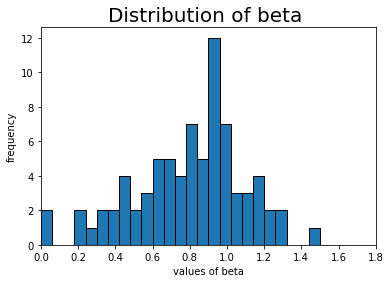

In [51]:
# Print the distribution of the parameters for column one for our estimates

print('Distribution of beta for column 1')
n_bins = 25
count, bins, ignored = plt.hist(dc1.b, n_bins, edgecolor='black')
plt.title('Distribution of beta ', fontsize=20)
plt.ylabel(r'frequency')
plt.xlabel(r'values of beta')
plt.xlim([0, 1.8]);

Distribution of betahat for column 1


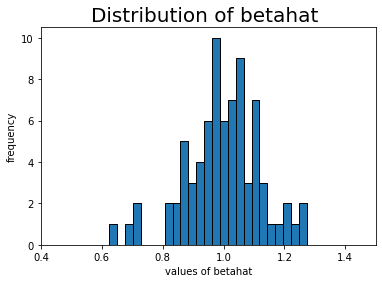

In [52]:
print('Distribution of betahat for column 1')
n_bins = 25
count, bins, ignored = plt.hist(dc1.bh, n_bins, edgecolor='black')
plt.title('Distribution of betahat ', fontsize=20)
plt.ylabel(r'frequency')
plt.xlabel(r'values of betahat')
plt.xlim([0.4, 1.5]);

Distribution of delta for column 1


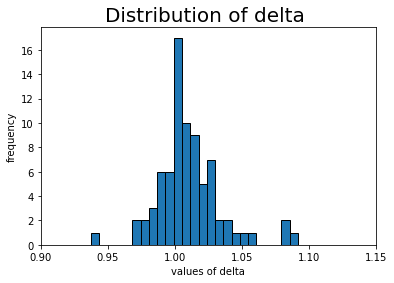

In [53]:
print('Distribution of delta for column 1')
n_bins = 25
count, bins, ignored = plt.hist(dc1.d, n_bins, edgecolor='black')
plt.title('Distribution of delta ', fontsize=20)
plt.ylabel(r'frequency')
plt.xlabel(r'values of delta')
plt.xlim([0.9, 1.15]);

Distribution of gamma for column 1


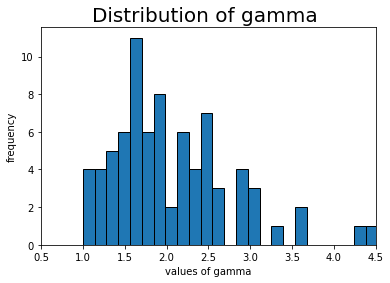

In [54]:
print('Distribution of gamma for column 1')
n_bins = 25
count, bins, ignored = plt.hist(dc1.g, n_bins, edgecolor='black')
plt.title('Distribution of gamma ', fontsize=20)
plt.ylabel(r'frequency')
plt.xlabel(r'values of gamma')
plt.xlim([0.5, 4.5]);

In [55]:
# save the results as a csv file

Table_2 = pd.DataFrame({'beta1':b1,'betahat1':bh1,'delta1':d1,'gamma1':g1,'phi1':p1,'sigma1':s1,
                        'beta2':b2,'betahat2':bh2,'delta2':d2,'gamma2':g2,'phi2':p2,'sigma2':s2,
                        'beta3':b3,'betahat3':bh3,'delta3':d3,'gamma3':g3,'phi3':p3,'sigma3':s3,
                        'beta4':b1,'betahat4':bh4,'delta4':d4,'gamma4':g4,'phi4':p4,'alpha4':a4,'sigma4':s4})

Table_2.to_csv('../output/table2_python.csv')